# Exploratory Data Analysis

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
from sleep_health.config import DATA_DIR

In [5]:
raw_data = pd.read_csv(DATA_DIR / 'raw' / 'Sleep_health_and_lifestyle_dataset.csv')

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


Several columns are objects, which means that we will need to transform those values.

In [7]:
raw_data.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


## Processing Columns

We can see that the NaN values in the sleep disorder represent that the person doesn't have one, we can replace the nan value for a string representing this case

In [8]:
interim_df = raw_data.copy()
interim_df["Sleep Disorder"].fillna("No Disorder", inplace=True)

/tmp/ipykernel_4747/341011658.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  interim_df["Sleep Disorder"].fillna("No Disorder", inplace=True)


We are going to need to convert all these columns to a numerical value:
1. Gender
2. Occupation
3. BMI Category
4. Sleep Disorder

We also will need to process the Blood Pressure column to split them into Systolic and Diastolic.

Processing the Blood Pressure Column

In [9]:
interim_df[['Systolic BP', 'Diastolic BP']] = interim_df["Blood Pressure"].str.split("/", expand=True).astype(int)
interim_df.drop(columns=["Blood Pressure"], inplace=True)
interim_df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic BP,Diastolic BP
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,No Disorder,126,83
1,2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,No Disorder,125,80
2,3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,No Disorder,125,80
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


Encoding the remaining columns (Gender,Occupation,BMI Category,Sleep Disorder)

In [10]:
interim_df[['Gender','Occupation','BMI Category','Sleep Disorder']]

,Gender,Occupation,BMI Category,Sleep Disorder
0,Male,Software Engineer,Overweight,No Disorder
1,Male,Doctor,Normal,No Disorder
2,Male,Doctor,Normal,No Disorder
3,Male,Sales Representative,Obese,Sleep Apnea
4,Male,Sales Representative,Obese,Sleep Apnea
...,...,...,...,...
369,Female,Nurse,Overweight,Sleep Apnea
370,Female,Nurse,Overweight,Sleep Apnea
371,Female,Nurse,Overweight,Sleep Apnea
372,Female,Nurse,Overweight,Sleep Apnea


In [11]:
interim_df['BMI Category'].value_counts()

BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

For the BMI Category column, makes sense to have the values converted in an order, for the other columns we can just use LabelEncoder.
Also, the categories "Normal" and "Normal Weight" are the same and we can unite them into one.

In [12]:
interim_df['BMI Category'].replace({'Normal Weight': 'Normal'}, inplace=True)
interim_df['BMI Category'].value_counts()

/tmp/ipykernel_4747/1150688915.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  interim_df['BMI Category'].replace({'Normal Weight': 'Normal'}, inplace=True)


BMI Category
Normal        216
Overweight    148
Obese          10
Name: count, dtype: int64

In [13]:

encoding_dict = {}

bmi_mapping = {"Normal": 0, "Overweight": 1, "Obese": 2}
interim_df["BMI Category Encoded"] = interim_df["BMI Category"].map(bmi_mapping)

encoding_dict["BMI Category"] = bmi_mapping

for column in ["Gender", "Occupation", "Sleep Disorder"]:
    encoder = LabelEncoder()
    interim_df[f"{column} Encoded"] = encoder.fit_transform(interim_df[column])

    # Creates a dictionairy to be easily saved as json
    encoding_dict[column] = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))


In [14]:
encoding_dict_json = {col: {k: int(v) for k, v in mapping.items()} for col, mapping in encoding_dict.items()}
with open(DATA_DIR / "encoding_dict.json", "w") as f:
    json.dump(encoding_dict_json, f)
decoding_dict = {col: {int(v): k for k, v in mapping.items()} for col, mapping in encoding_dict.items()}
with open(DATA_DIR / "decoding_dict.json", "w") as f:
    json.dump(decoding_dict, f)


In [15]:
interim_df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic BP,Diastolic BP,BMI Category Encoded,Gender Encoded,Occupation Encoded,Sleep Disorder Encoded
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,No Disorder,126,83,1,1,9,1
1,2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,No Disorder,125,80,0,1,1,1
2,3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,No Disorder,125,80,0,1,1,1
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90,2,1,6,2
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90,2,1,6,2


In [16]:
processed_df = interim_df.drop(columns=['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder'])

In [17]:
with open(DATA_DIR / 'processed' / 'processed_data.csv', 'w') as f:
    processed_df.to_csv(f, index=False)

In [18]:
processed_df['Quality of Sleep'].value_counts()

Quality of Sleep
8    109
6    105
7     77
9     71
5      7
4      5
Name: count, dtype: int64

## Data visualization

### Features Histograms and First Thoughts

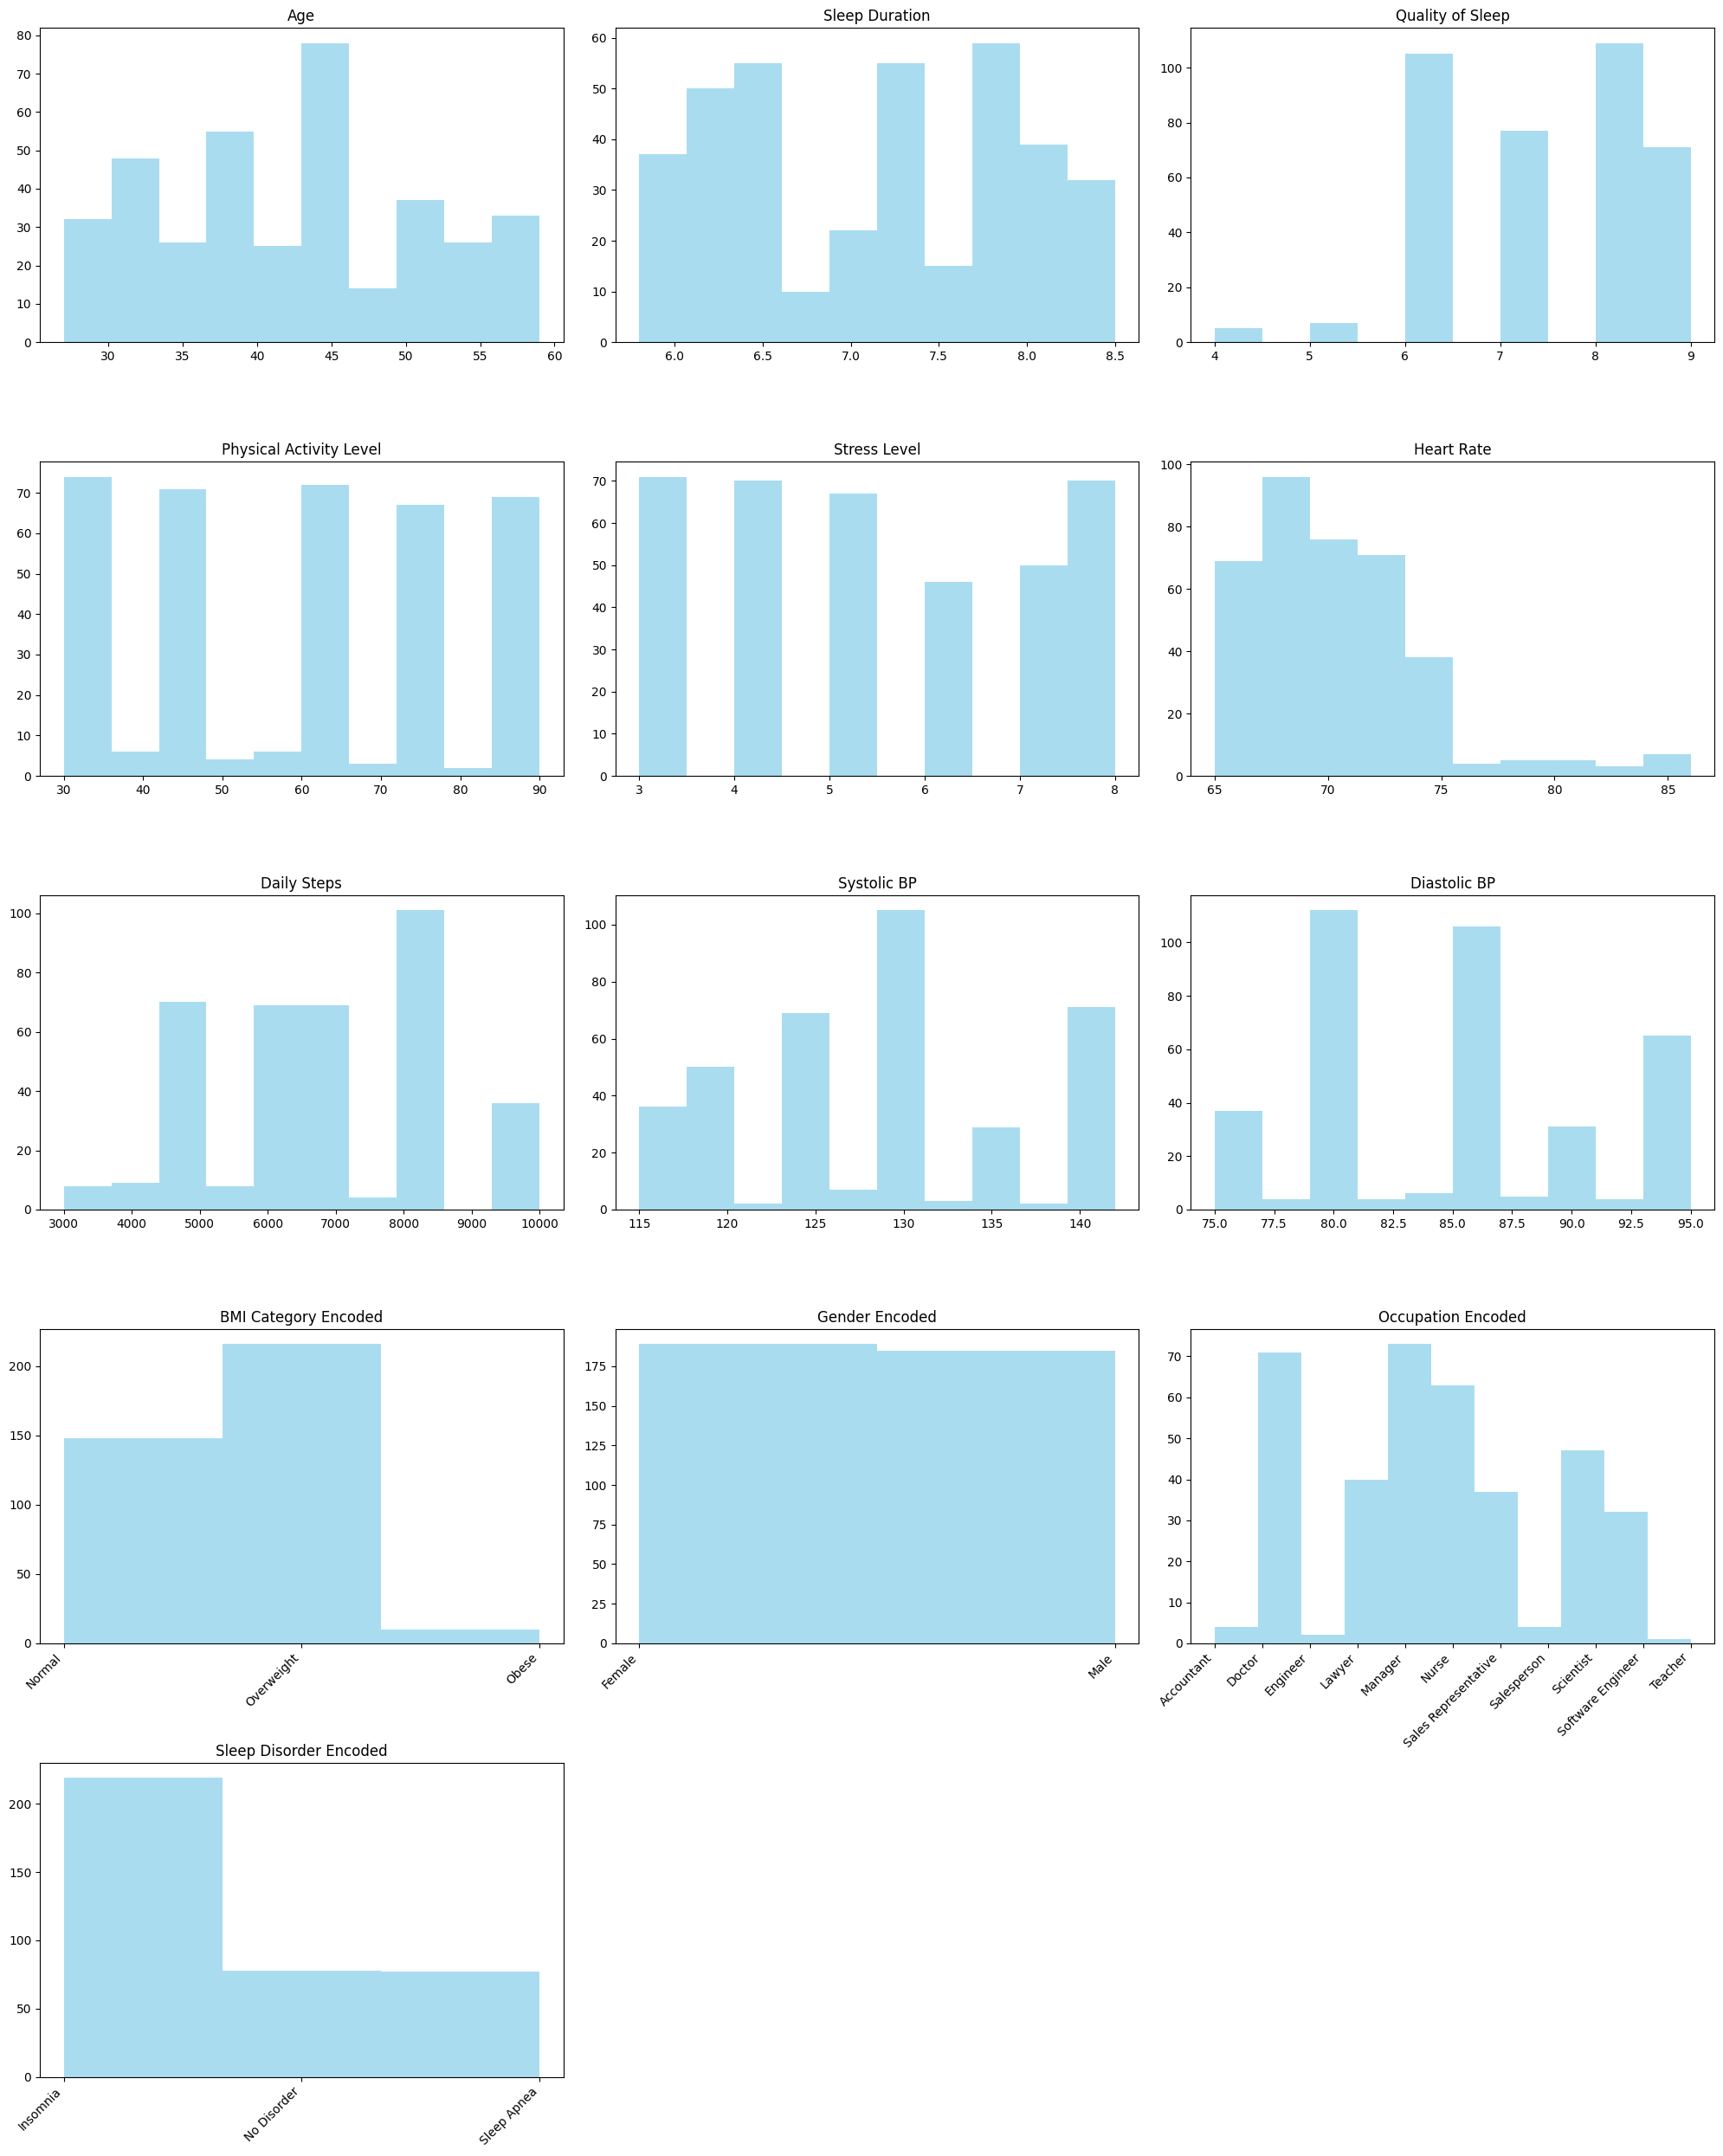

In [19]:
import matplotlib.pyplot as plt

# Only meaningful columns
features = [col for col in processed_df.columns if col not in ["Person ID"]]

num_features = len(features)
rows = (num_features // 3) + (num_features % 3 > 0)  

# Subplot grid
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(20, 5 * rows))
axes = axes.flatten()


for i, feature in enumerate(features):
    ax = axes[i]
    
    # If the feature is encoded we will decode the labels
    if "Encoded" in feature and feature.replace(" Encoded", "") in decoding_dict:  # Verifica se precisa decodificar
        decoder = decoding_dict[feature.replace(" Encoded", "")]
        decoded_values = processed_df[feature].map(decoder).dropna()  # Aplica decodificação
        ax.hist(decoded_values, bins=len(set(decoded_values)), color="skyblue", alpha=0.7)
        ax.set_xticks(range(len(decoder)))  # Mantém espaçamento adequado
        ax.set_xticklabels(decoder.values(), rotation=45, ha='right')  # Aplica labels decodificados
    else:
        ax.hist(processed_df[feature], color="skyblue", alpha=0.7)
    ax.set_title(feature)

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

# Ajusta espaçamento entre subplots
plt.tight_layout()
plt.show()


We can gather a few information from these visualizations:
* The age of the sample seems balanced, with a little bit more around the age of 45
* The quality of sleep of the sample is very centered in the 6-9 interval
* Most of the people in this study practice at least 30 minutes of physical activity daily, which is surprising.
* The resting heart rate of the individuals more frequent in the 60 to 75 interval
* The Daily steps of most of the sample is above 5000 which seems to be high in agreeance with the physical activity level
* Few people that seems to be have high blood pressure (SBP around 140 and DBP around 95)
* Very few obese people is also expected due to the physical activity feature
* A lot of people with insomnia

### 

### Analysing Features Against the target Variable

The target variable in this study is the quality of sleep of the participants. It's a score ranging from 1 to 10

In [26]:
processed_df['Quality of Sleep'].value_counts()

Quality of Sleep
8    109
6    105
7     77
9     71
5      7
4      5
Name: count, dtype: int64

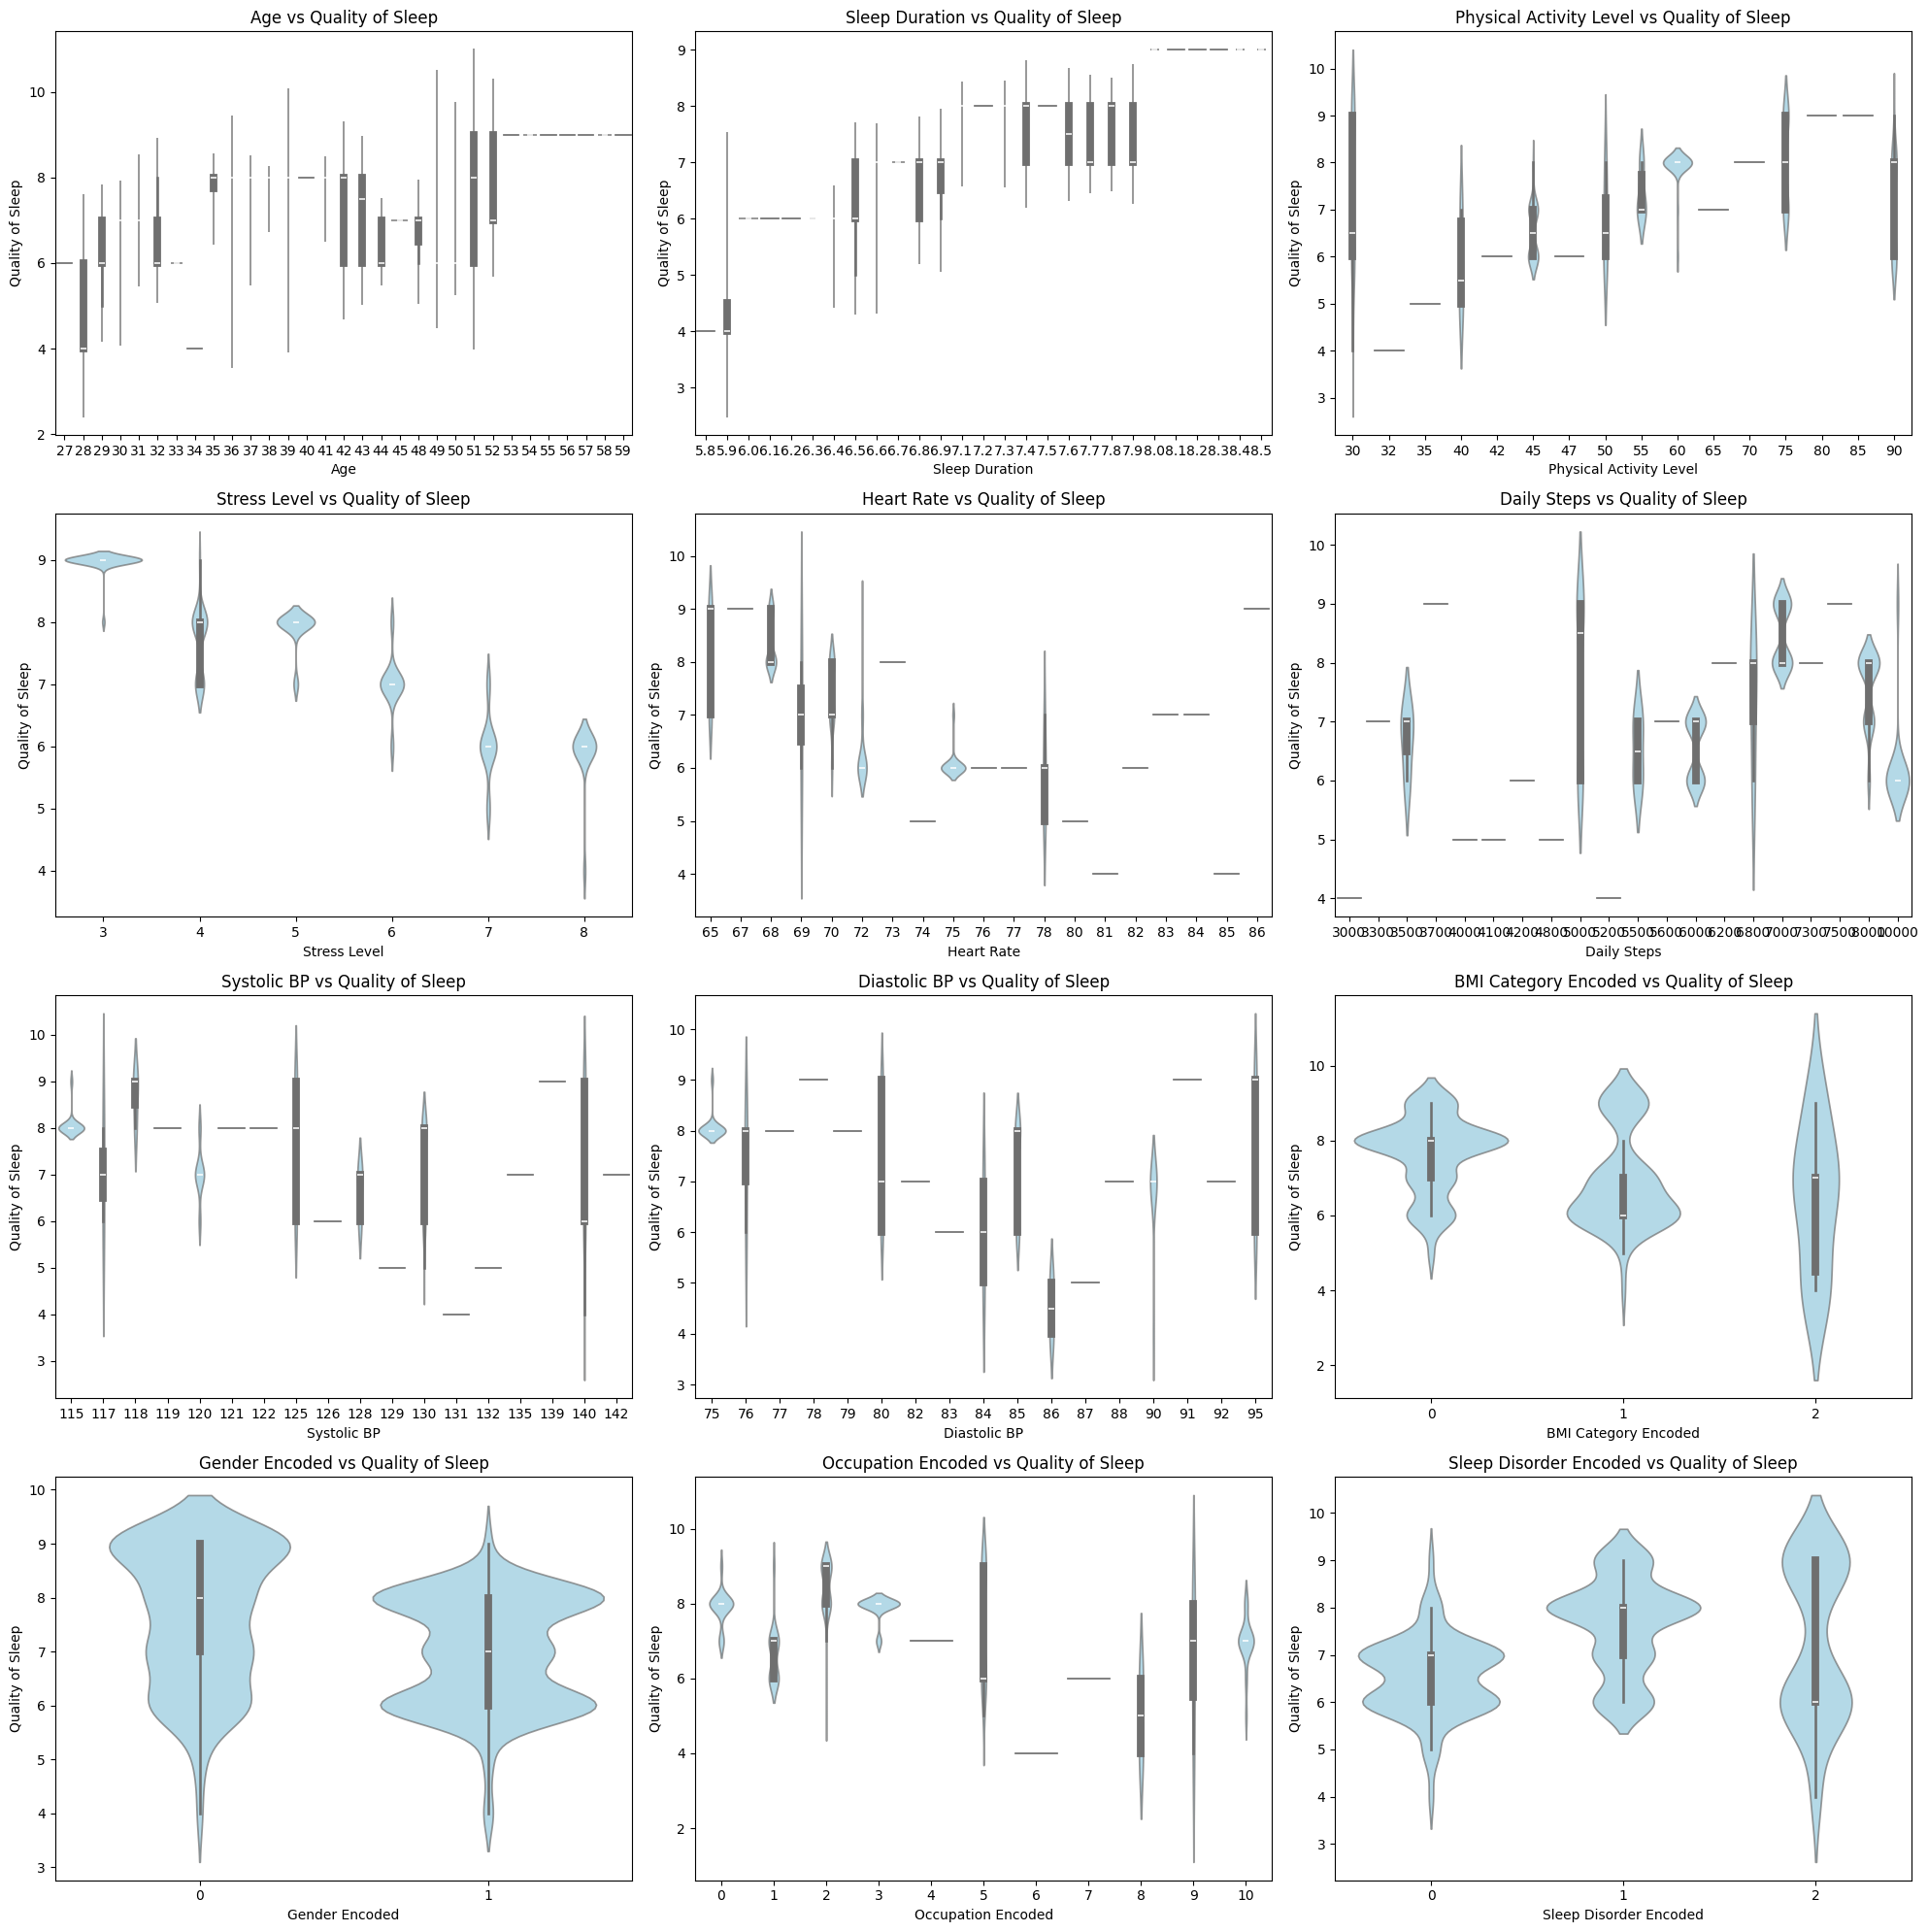

In [25]:
target_col = "Quality of Sleep"

features = [col for col in processed_df.columns if col != target_col and col != 'Person ID']

# Create subplots
num_features = len(features)
rows = (num_features // 3) + (num_features % 3 > 0)
fig, axes = plt.subplots(nrows=rows, ncols=3, figsize=(20, 5 * rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    sns.violinplot(x=processed_df[feature], y=processed_df[target_col], ax=ax, color="skyblue", alpha=0.7)
    ax.set_title(f"{feature} vs {target_col}")

# Remove empty subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

For this study we are focusing on the sleep quality and thats